Loaded trained model successfully
Saved ECG data to extracted_fecg.csv


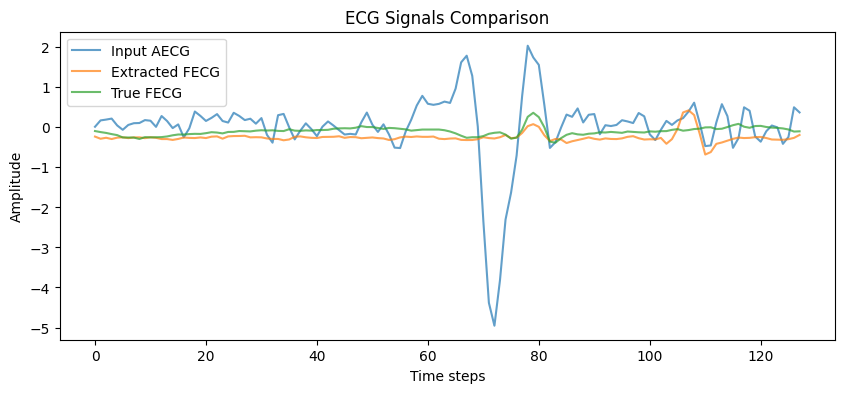

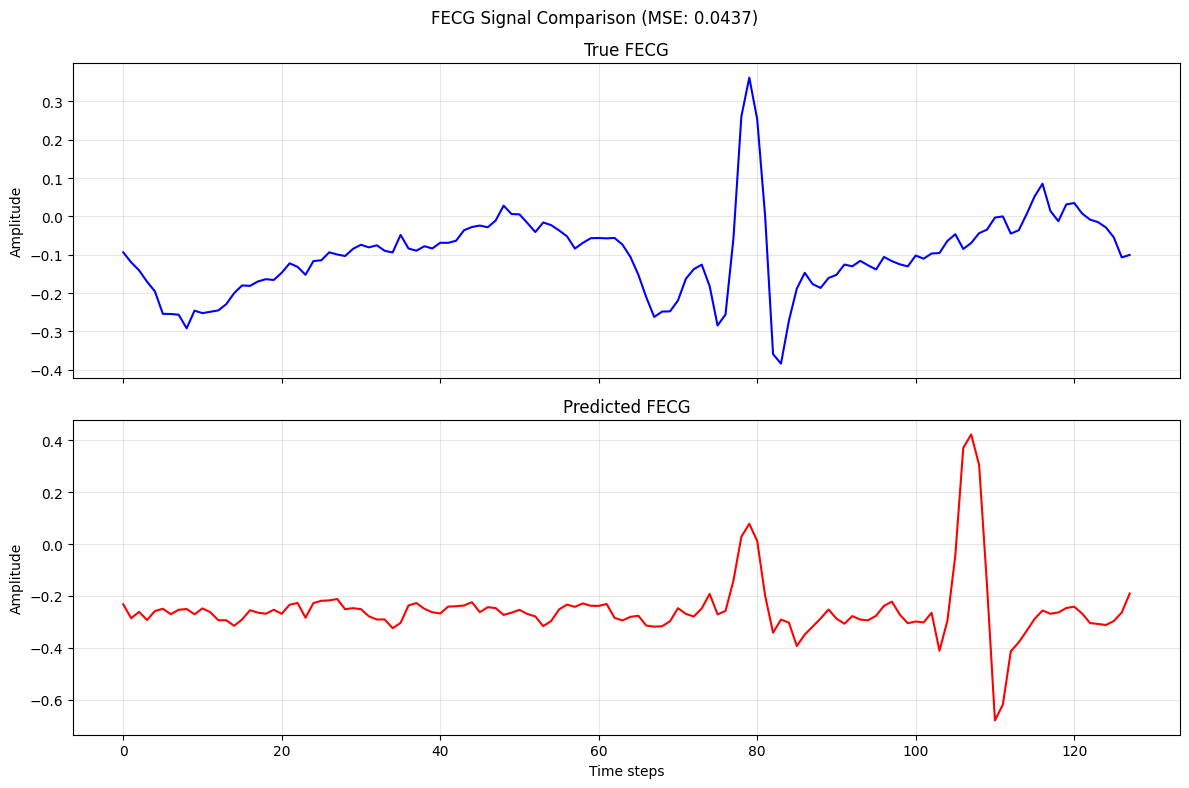

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

# Assuming all the classes and functions from your training code are available
# (DataUtils, TrainUtils, Data_Loader, Data_Item, FECGDataset, Generator, etc.)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import pyedflib
from scipy import signal
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import scale
import padasip as pa
import wfdb
import time
import datetime
from tqdm import tqdm
import os

import argparse
# Spectral Normalization class
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

# Sin activation
class Sin_activate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        x=x.sin()
        return x

# DataUtils class
class DataUtils:
    def __init__(self) -> None:
        super().__init__()
        self.fileNames = ["r01.edf", "r04.edf", "r07.edf", "r08.edf", "r10.edf"]

    def readData(self, sigNum, path="/content/drive/MyDrive/Colab Notebooks/EDP/ADFECGDB/"):
        file_name = path + self.fileNames[sigNum]
        f = pyedflib.EdfReader(file_name)
        n = f.signals_in_file
        abdECG = np.zeros((n - 1, f.getNSamples()[0]))
        fetalECG = np.zeros((1, f.getNSamples()[0]))
        fetalECG[0, :] = f.readSignal(0)
        fetalECG[0, :] = scale(self.SignalFilter(self.butter_bandpass_filter(fetalECG, 1, 100, 1000)), axis=1)
        for i in np.arange(1, n):
            abdECG[i - 1, :] = f.readSignal(i)
        abdECG = scale(self.SignalFilter(self.butter_bandpass_filter(abdECG, 1, 100, 1000)), axis=1)

        abdECG = signal.resample(abdECG, int(abdECG.shape[1] / 5), axis=1)
        fetalECG = signal.resample(fetalECG, int(fetalECG.shape[1] / 5), axis=1)

        signal_annotation = wfdb.rdann(file_name, "qrs", sampfrom=0, sampto=60000*5)
        fqrs_rpeaks = signal_annotation.sample
        fqrs_rpeaks = np.asarray(np.floor_divide(fqrs_rpeaks,5),'int64')

        return abdECG, fetalECG, fqrs_rpeaks

    def windowingSig(self, sig1, sig2, fqrs_rpeaks, windowSize=15):
        signalLen = sig2.shape[1]
        signalsWindow1 = [sig1[:, int(i):int(i + windowSize)].transpose() for i in range(0, signalLen - windowSize, windowSize)]
        signalsWindow2 = [sig2[:, int(i):int(i + windowSize)].transpose() for i in range(0, signalLen - windowSize, windowSize)]

        fqrsWindows = []

        ik = 0
        for i in range(0, signalLen - windowSize, windowSize):
            fqrs = []

            while (fqrs_rpeaks[ik] < int(i + windowSize)):
                index = fqrs_rpeaks[ik]
                if index in range (int(i),int(i + windowSize)):
                    fqrs.append(index - int(i))
                    ik = ik +1
            fqrsWindows.append(fqrs)

        return signalsWindow1, signalsWindow2, fqrsWindows

    def adaptFilterOnSig(self, src, ref):
        f = pa.filters.FilterNLMS(n=4, mu=0.1, w="random")
        for index, sig in enumerate(src):
            try:
                y, e, w = f.run(ref[index][:, 0], sig)
                ref[index][:, 0] = e
            except:
                pass
        return ref

    def calculateICA(self, sdSig, component=7):
        ica = FastICA(n_components=component, max_iter=1000)
        icaRes = []
        for index, sig in enumerate(sdSig):
            try:
                icaSignal = np.array(ica.fit_transform(sig))
                icaSignal = np.append(icaSignal, sig[:, range(2, 4)], axis=1)
                icaRes.append(icaSignal)
            except:
                pass
        return np.array(icaRes)

    def createDelayRepetition(self, signal, numberDelay=4, delay=10):
        signal = np.repeat(signal, numberDelay, axis=0)
        for row in range(1, signal.shape[0]):
            signal[row, :] = np.roll(signal[row, :], shift=delay * row)
        return signal

    def __butter_bandpass(self, lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=3, axis=1):
        b, a = self.__butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data, axis=axis)
        return y

    def SignalFilter(self, filtedData):
        A = np.array([1,0,0,0,0,0,0,0,0,0,-0.854])
        B = np.array([0.927,0,0,0,0,0,0,0,0,0,-0.927])
        filtedData = signal.filtfilt(B, A, filtedData)

        B1 = np.array([0.995,-1.8504,0.995])
        A1 = np.array([1,-1.8505,0.99])
        filtedData = signal.filtfilt(B1, A1, filtedData)

        B2 = np.array([0.388,0.388])
        A2 = np.array([1,-0.42578])
        filtedData = signal.filtfilt(B2, A2, filtedData)
        return filtedData

    def normalize(self, v):
        v_min = v.min(axis=1).reshape((v.shape[0],1))
        v_max = v.max(axis=1).reshape((v.shape[0],1))
        return (v - v_min) / (v_max-v_min)

# TrainUtils class
class TrainUtils:
    def __init__(self) -> None:
        super().__init__()
        self.dataUtils = DataUtils()

    def prepareData(self, delay=5):
        ecgAll, fecg, fqrs_rpeaks = self.dataUtils.readData(1)
        ecgAll = ecgAll[range(1), :]
        delayNum = ecgAll.shape[0]
        fecgAll = self.dataUtils.createDelayRepetition(fecg, delayNum, delay)
        for i in range(2, 5):
            ecg, fecg, fqrs_rpeaks1 = self.dataUtils.readData(i)
            ecg = ecg[range(1), :]

            fqrs_rpeaks1 = fqrs_rpeaks1 + 60000*(i-1)
            fqrs_rpeaks = np.append(fqrs_rpeaks, fqrs_rpeaks1)
            fecgDelayed = self.dataUtils.createDelayRepetition(fecg, delayNum, delay)
            ecgAll = np.append(ecgAll, ecg, axis=1)
            fecgAll = np.append(fecgAll, fecgDelayed, axis=1)

        ecgWindows, fecgWindows, fqrs_rpeaks = self.dataUtils.windowingSig(ecgAll, fecgAll, fqrs_rpeaks, windowSize=128)
        return ecgWindows, fecgWindows, fqrs_rpeaks

    def trainTestSplit(self, sig, label, trainPercent, shuffle=False):
        X_train, X_test, y_train, y_test = train_test_split(sig, label, train_size=trainPercent, shuffle=shuffle)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        return X_train, X_test, y_train, y_test

# Data_Loader class
class Data_Loader():
    def __init__(self, FECG=True):
        super().__init__()
        self.trainUtils = TrainUtils()

    def test_trainSignal(self):
        ecgWindows, fecgWindows, fqrs_rpeaks = self.trainUtils.prepareData(delay=5)
        X_train, X_test, Y_train, Y_test = self.trainUtils.trainTestSplit(ecgWindows, fecgWindows, len(ecgWindows)-1)

        X_train = np.reshape(X_train, [-1, X_train.shape[2], X_train.shape[1]])
        X_test = np.reshape(X_test, [-1, X_test.shape[2], X_test.shape[1]])
        Y_train = np.reshape(Y_train, [-1, Y_train.shape[2], Y_train.shape[1]])
        Y_test = np.reshape(Y_test, [-1, Y_test.shape[2], Y_test.shape[1]])

        return X_train, X_test, Y_train, Y_test, fqrs_rpeaks

# Data_Item class
class Data_Item():
    def __init__(self, FECG=True):
        super().__init__()
        self.X_train, self.X_test, self.Y_train, self.Y_test, self.fqrs_rpeaks = Data_Loader().test_trainSignal()

# FECGDataset class
class FECGDataset(Dataset):
    def __init__(self, data_item, train=True):
        super(FECGDataset, self).__init__()
        self.train = train
        self.X_train, self.X_test, self.Y_train, self.Y_test, self.fqrs_rpeaks = data_item.X_train, data_item.X_test, data_item.Y_train, data_item.Y_test, data_item.fqrs_rpeaks
        self.numer = len(self.X_train)

    def __getitem__(self, index):
        if self.train:
            xx = self.X_train[index,:,:]
            yy = self.Y_train[index,:,:]
            fqrs = self.fqrs_rpeaks[index]

            y_max_index = np.argmax(yy,axis=-1)
            y_min_index = np.argmin(yy,axis=-1)

            x_max = xx[0,y_max_index]
            x_min = xx[0,y_min_index]

            t_max = 10000
            t_min = 0
            for coo in fqrs:
                v_max = np.max(xx[0,max(coo-10,0):min(coo+10,127)])
                if t_max > v_max:
                    t_max = v_max
                    v_min = np.min(xx[0,max(coo-10,0):min(coo+10,127)])
                    t_min = v_min

            if t_max == np.max(xx[0,:]) or t_min == np.min(xx[0,:]):
                index1 = index-1 if (index+1 == self.numer) else index+1
                xx = self.X_train[index1,:,:]
                yy = self.Y_train[index1,:,:]
                fqrs = self.fqrs_rpeaks[index1]

                y_max_index = np.argmax(yy,axis=-1)
                y_min_index = np.argmin(yy,axis=-1)

                x_max = xx[0,y_max_index]
                x_min = xx[0,y_min_index]

                t_max = 10000
                t_min = 0
                for coo in fqrs:
                    v_max = np.max(xx[0,max(coo-10,0):min(coo+10,127)])
                    if t_max > v_max:
                        t_max = v_max
                        t_min = np.min(xx[0,max(coo-10,0):min(coo+10,127)])

            min_max_scaler = MinMaxScaler(feature_range=(t_min, t_max), copy=False)
            yy_minmax = min_max_scaler.fit_transform(yy.transpose())
            MECG_signal =  xx - yy_minmax.transpose()

            M_index = np.argmax(MECG_signal,axis=-1)
            noise = MECG_signal.copy()
            M_index = int(M_index.item() if hasattr(M_index, 'item') else M_index)  # Force scalar
            noise[0, max(0,M_index-15):min(MECG_signal.shape[-1],M_index+15)] = noise[0, max(0,M_index-15)]

            min_max_scaler = MinMaxScaler(feature_range=(-1, 1), copy=False)
            MECG_signal = min_max_scaler.fit_transform(MECG_signal.transpose()).transpose()
            AECG_signal = min_max_scaler.fit_transform(self.X_train[index,:,:].transpose()).transpose()
            FECG_signal = min_max_scaler.fit_transform(self.Y_train[index,:,:].transpose()).transpose()
            BIAS_signal = min_max_scaler.fit_transform(noise.transpose()).transpose()

            return AECG_signal, FECG_signal, MECG_signal, BIAS_signal
        else:
            xx = self.X_test[index,:,:]
            yy = self.Y_test[index,:,:]
            fqrs = self.fqrs_rpeaks[index]

            y_max_index = np.argmax(yy,axis=-1)
            y_min_index = np.argmin(yy,axis=-1)

            x_max = xx[0,y_max_index]
            x_min = xx[0,y_min_index]

            t_max = 10000
            t_min = 0
            for coo in fqrs:
                v_max = np.max(xx[0,max(coo-10,0):min(coo+10,127)])
                if t_max > v_max:
                    t_max = v_max
                    v_min = np.min(xx[0,max(coo-10,0):min(coo+10,127)])
                    t_min = v_min

            if t_max == np.max(xx[0,:]) or t_min == np.min(xx[0,:]):
                index1 = index-1 if (index+1 == self.numer) else index+1
                xx = self.X_test[index1,:,:]
                yy = self.Y_test[index1,:,:]
                fqrs = self.fqrs_rpeaks[index1]

                y_max_index = np.argmax(yy,axis=-1)
                y_min_index = np.argmin(yy,axis=-1)

                x_max = xx[0,y_max_index]
                x_min = xx[0,y_min_index]

                t_max = 10000
                t_min = 0
                for coo in fqrs:
                    v_max = np.max(xx[0,max(coo-10,0):min(coo+10,127)])
                    if t_max > v_max:
                        t_max = v_max
                        t_min = np.min(xx[0,max(coo-10,0):min(coo+10,127)])

            min_max_scaler = MinMaxScaler(feature_range=(t_min, t_max), copy=False)
            yy_minmax = min_max_scaler.fit_transform(yy.transpose())
            MECG_signal =  xx - yy_minmax.transpose()

            M_index = np.argmax(MECG_signal,axis=-1)
            noise = MECG_signal.copy()
            M_index = int(M_index.item() if hasattr(M_index, 'item') else M_index)  # Force scalar
            noise[0, max(0,M_index-15):min(MECG_signal.shape[-1],M_index+15)] = noise[0, max(0,M_index-15)]

            return self.X_test[index,:,:], self.Y_test[index,:,:], MECG_signal, noise

    def __len__(self):
        return len(self.X_train)

# Utility functions
def make_folder(path, version):
    if not os.path.exists(os.path.join(path, version)):
        os.makedirs(os.path.join(path, version))

def tensor2var(x, grad=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=grad)

def var2tensor(x):
    return x.data.cpu()

def var2numpy(x):
    return x.data.cpu().numpy()

def denorm1(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

def denorm(v):
    v_min = v.min(axis=2).reshape((v.shape[0],1,1))
    v_max = v.max(axis=2).reshape((v.shape[0],1,1))
    return (v - v_min) / (v_max-v_min)

# Model components
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        layer = []
        layer.append(nn.Conv1d(in_features, in_features, 3, padding=[1]))
        layer.append(nn.InstanceNorm1d(in_features))
        layer.append(Sin_activate())
        layer.append(nn.Conv1d(in_features, in_features, 3, padding=[1]))
        layer.append(nn.InstanceNorm1d(in_features))
        layer.append(Sin_activate())
        self.conv_block = nn.Sequential(*layer)

    def forward(self, x):
        return self.conv_block(x)

class CoAtt(nn.Module):
    def __init__(self, in_dim):
        super(CoAtt, self).__init__()
        self.chanel_in = in_dim
        self.query_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        mean, std = torch.mean(x), torch.std(x)
        x_zscore = (x-mean)/std
        m_batchsize_z, C_z, width_z = x_zscore.size()
        height_z = 1
        x_transpose = x_zscore.view(m_batchsize_z,-1,width_z*height_z).permute(0,2,1)

        m_batchsize, C, width = x.size()
        height = 1
        proj_query = self.query_conv(x).view(m_batchsize,-1,width*height)
        query_energy = torch.bmm(x_transpose, proj_query).permute(0,2,1)

        x_flatten = x_zscore.view(m_batchsize_z,-1,width_z*height_z)
        proj_key = self.key_conv(x).view(m_batchsize,-1,width*height)
        key_energy = torch.bmm(x_transpose, proj_key)

        energy = torch.bmm(query_energy, key_energy)
        attention = self.softmax(energy)

        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height)
        out = torch.bmm(proj_value, attention.permute(0,2,1))
        out = self.gamma*out + x_flatten
        out = out.view(m_batchsize, C, width)
        return out

class CCAR(nn.Module):
    def __init__(self, in_dim):
        super(CCAR, self).__init__()
        self.chanel_in = in_dim
        self.query_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.residual = ResidualBlock(in_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        g = self.residual(x)
        x_g = x + g

        mean, std = torch.mean(x_g), torch.std(x_g)
        x_g_zscore = (x_g-mean)/std
        m_batchsize_x_g, C_x_g, width_x_g = x_g_zscore.size()
        height_x_g = 1
        x_g_transpose = x_g_zscore.view(m_batchsize_x_g,-1,width_x_g*height_x_g).permute(0,2,1)

        m_batchsize, C, width = x_g.size()
        height = 1
        proj_query = self.query_conv(x_g).view(m_batchsize,-1,width*height)
        query_energy = torch.bmm(x_g_transpose, proj_query).permute(0,2,1)

        mean, std = torch.mean(g), torch.std(g)
        g_zscore = (g-mean)/std
        m_batchsize_g, C_g, width_g = x_g_zscore.size()
        height_g = 1
        g_flatten = g_zscore.view(m_batchsize_g,-1,width_g*height_g)
        g_transpose = g_flatten.permute(0,2,1)

        proj_key = self.key_conv(g).view(m_batchsize_g,-1,width_g*height_g)
        key_energy = torch.bmm(g_transpose, proj_key)
        energy = torch.bmm(query_energy, key_energy)
        attention = self.softmax(energy)

        proj_value = self.value_conv(g).view(m_batchsize_g,-1,width_g*height_g)
        out = torch.bmm(proj_value, attention.permute(0,2,1))
        out = out.view(m_batchsize, C, width)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(rate)

    def forward(self, inputs):
        attn_output, attn_output_weights = self.att(inputs, inputs, inputs)
        attn_output = self.dropout(attn_output)
        out = self.layernorm(inputs * attn_output)
        return out

# Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        self.transformer = TransformerBlock(128, 2)

        self.conv1DWithSINE_l0 = nn.Sequential(nn.Conv1d(1,1,31, padding=[15]), nn.InstanceNorm1d(1), Sin_activate())
        self.conv1DWithSINE_l1 = nn.Sequential(nn.Conv1d(1,5,3, padding=[1]), nn.InstanceNorm1d(5), Sin_activate())
        self.conv1DWithSINE_l2 = nn.Sequential(nn.Conv1d(5,7,13, padding=[6]), nn.InstanceNorm1d(7), Sin_activate())
        self.conv1DWithSINE_l3 = nn.Sequential(nn.Conv1d(7,13,5, padding=[2]), nn.InstanceNorm1d(13), Sin_activate(), CoAtt(13))

        self.conv1DWithSINE_r3 = nn.Sequential(nn.Conv1d(13,7,5, padding=[2]), nn.InstanceNorm1d(7), Sin_activate())
        self.conv1DWithSINE_r2 = nn.Sequential(nn.Conv1d(7,5,13, padding=[6]), nn.InstanceNorm1d(5), Sin_activate())
        self.conv1DWithSINE_r1 = nn.Sequential(nn.Conv1d(5,1,3, padding=[1]))

        self.ccar1 = CCAR(5)
        self.ccar2 = CCAR(7)
        self.ccar3 = CCAR(13)

    def forward(self, z):
        value = self.conv1DWithSINE_l0(z.to(torch.float32))
        att = self.transformer(value)
        mean, std = torch.mean(att), torch.std(att)
        att = (att-mean)/std
        l00 = value * torch.clamp(att, 0.8, 1)

        l01 = self.conv1DWithSINE_l1(l00)
        l02 = self.conv1DWithSINE_l2(l01)
        l03 = self.conv1DWithSINE_l3(l02)

        l03_ccar = self.ccar3(l03)
        l02_ccar = self.ccar2(l02)
        l01_ccar = self.ccar1(l01)

        l03 = l03 + l03_ccar
        r03 = self.conv1DWithSINE_r3(l03)
        r03 = r03 + l02_ccar
        r02 = self.conv1DWithSINE_r2(r03)
        r02 = r02 + l01_ccar
        r01 = self.conv1DWithSINE_r1(r02)
        return r01

class Discriminator(nn.Module):
    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1DWithSINE0 = nn.Sequential(nn.Conv1d(1,12,5, padding=[2]), nn.InstanceNorm1d(12), Sin_activate())
        self.conv1DWithSINE1 = nn.Sequential(nn.Conv1d(12,7,5, padding=[2]), nn.InstanceNorm1d(7), Sin_activate())
        self.conv1DWithSINE2 = nn.Sequential(nn.Conv1d(7,3,5, padding=[2]), nn.InstanceNorm1d(3), Sin_activate())
        self.conv1DWithSINE3 = nn.Sequential(nn.Conv1d(3,1,5, padding=[2]), nn.InstanceNorm1d(1), Sin_activate())

        self.attn1 = CoAtt(256)
        self.attn2 = CoAtt(512)
        self.attn3 = CoAtt(1024)

    def forward(self, x):
        out = self.conv1DWithSINE0(x.to(torch.float32))
        out = self.conv1DWithSINE1(out)
        out = self.conv1DWithSINE2(out)
        out = self.conv1DWithSINE3(out)
        return out

# Training components
class logcosh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, true, pred):
        loss = torch.log(torch.cosh(pred - true))
        return torch.sum(loss)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal1(m):
    if isinstance(m, nn.Conv1d):
        m.weight.data.normal_(0, 0.1)
        m.bias.data.zero_()
    elif isinstance(m, nn.InstanceNorm1d):
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias, 0)

def weights_init_normal(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.InstanceNorm1d):
        pass

# Trainer class
class Trainer(object):
    def __init__(self, data_loader, config):
        self.data_loader = data_loader
        self.model = config.model
        self.adv_loss = config.adv_loss

        # Model hyper-parameters
        self.imsize = config.imsize
        self.g_num = config.g_num
        self.z_dim = config.z_dim
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.parallel = config.parallel

        self.lambda_gp = config.lambda_gp
        self.total_step = config.total_step
        self.d_iters = config.d_iters
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers
        self.g_AECG_lr = config.g_AECG_lr
        self.g_MECG_lr = config.g_MECG_lr
        self.g_FECG_lr = config.g_FECG_lr
        self.g_BIAS_lr = config.g_BIAS_lr

        self.d_AECG_lr = config.d_AECG_lr
        self.d_MECG_lr = config.d_MECG_lr
        self.d_FECG_lr = config.d_FECG_lr
        self.d_BIAS_lr = config.d_BIAS_lr

        self.decay_start_epoch = round(config.total_step / config.batch_size) - 1
        self.decay_start_epoch = 1

        self.lr_decay = config.lr_decay
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.pretrained_model = config.pretrained_model

        self.dataset = config.dataset
        self.use_tensorboard = config.use_tensorboard
        self.image_path = config.image_path
        self.log_path = config.log_path
        self.model_save_path = config.model_save_path
        self.sample_path = config.sample_path
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.model_save_step = config.model_save_step
        self.version = config.version

        self.log_path = os.path.join(config.log_path, self.version)
        self.sample_path = os.path.join(config.sample_path, self.version)
        self.model_save_path = os.path.join(config.model_save_path, self.version)

        self.build_model()

        self.gamma_FECG_fake = nn.Parameter(torch.zeros(1)).to(device)
        self.lambda_MECG_fake = nn.Parameter(torch.zeros(1)).to(device)
        self.beta_BIAS_fake = nn.Parameter(torch.zeros(1)).to(device)

        self.gamma_FECG_reconstr = nn.Parameter(torch.zeros(1)).to(device)
        self.lambda_MECG_reconstr = nn.Parameter(torch.zeros(1)).to(device)
        self.beta_BIAS_reconstr = nn.Parameter(torch.zeros(1)).to(device)

        self.gamma_AECG_loss = nn.Parameter(torch.ones(1)*0.8).to(device)
        self.gamma_FECG_loss = nn.Parameter(torch.ones(1)*0.4).to(device)
        self.gamma_MECG_loss = nn.Parameter(torch.ones(1)*0.4).to(device)
        self.gamma_BIAS_loss = nn.Parameter(torch.ones(1)*0.2).to(device)

        if self.use_tensorboard:
            self.build_tensorboard()

        if self.pretrained_model:
            self.load_pretrained_model()

    def train(self):
        model_save_step = int(self.model_save_step)

        if self.pretrained_model:
            start = self.pretrained_model + 1
        else:
            start = 0

        self.model_train()
        start_time = time.time()
        loss_c = 10000
        MECG_factor = 5.0
        FECG_factor = 5.0
        BIAS_factor = 0.5

        for step in range(start, self.total_step):
            tbar = tqdm(self.data_loader, desc='epoch'+str(step))
            for AECG_signals, FECG_signals, MECG_signals, BIAS_signals in tbar:
                valid = torch.ones((AECG_signals.shape[0],1,128), dtype=torch.float32).to(device)
                fake = torch.zeros((AECG_signals.shape[0],1,128), dtype=torch.float32).to(device)

                AECG_signals = AECG_signals.to(device)
                FECG_signals = FECG_signals.to(device)
                MECG_signals = MECG_signals.to(device)
                BIAS_signals = BIAS_signals.to(device)

                self.optimizer_G_zero_grad()

                # AECG to MECG
                same_MECG_signals = self.G_AECG2MECG(AECG_signals)
                loss_generator_MECG = self.loss_generator(same_MECG_signals, MECG_signals.float())*1
                same_AECG_signals = self.G_MECG2AECG(MECG_signals)
                loss_generator_AECG = self.loss_generator(same_AECG_signals, AECG_signals.float())*1

                fake_MECG_signals = self.G_AECG2MECG(AECG_signals)
                pred_fake_MECG_signals = self.D_AECG2MECG(fake_MECG_signals)
                loss_forwardGAN_AECG2MECG = self.loss_forwardGAN(pred_fake_MECG_signals, valid)

                fake_AECG_signals_from_MECG = self.G_MECG2AECG(MECG_signals)
                pred_fake_AECG_signals_from_MECG = self.D_MECG2AECG(fake_AECG_signals_from_MECG)
                loss_forwardGAN_MECG2AECG = self.loss_forwardGAN(pred_fake_AECG_signals_from_MECG, valid)

                reconstr_AECG_signals_from_MECG = self.G_MECG2AECG(fake_MECG_signals)
                loss_cycleGAN_AECG2MECG2AECG = self.loss_cycleGAN(reconstr_AECG_signals_from_MECG, AECG_signals.float())*0.04

                reconstr_MECG_signals = self.G_AECG2MECG(fake_AECG_signals_from_MECG)
                loss_cycleGAN_MECG2AECG2MECG = self.loss_cycleGAN(reconstr_MECG_signals, MECG_signals.float())*0.04

                loss_G_total_AECG2MECG = loss_generator_MECG + loss_generator_AECG + loss_forwardGAN_AECG2MECG + loss_forwardGAN_MECG2AECG + loss_cycleGAN_AECG2MECG2AECG + loss_cycleGAN_MECG2AECG2MECG
                loss_G_total_AECG2MECG.backward(retain_graph=True)

                # AECG to FECG
                same_FECG_signals = self.G_AECG2FECG(AECG_signals)
                loss_generator_FECG = self.loss_generator(same_FECG_signals, FECG_signals.float())*4
                same_AECG_signals = self.G_FECG2AECG(FECG_signals)
                loss_generator_AECG = self.loss_generator(same_AECG_signals, AECG_signals.float())*4

                fake_FECG_signals = self.G_AECG2FECG(AECG_signals)
                pred_fake_FECG_signals = self.D_AECG2FECG(fake_FECG_signals)
                loss_forwardGAN_AECG2FECG = self.loss_forwardGAN(pred_fake_FECG_signals, valid)

                fake_AECG_signals_from_FECG = self.G_FECG2AECG(FECG_signals)
                pred_fake_AECG_signals_from_FECG = self.D_FECG2AECG(fake_AECG_signals_from_FECG)
                loss_forwardGAN_FECG2AECG = self.loss_forwardGAN(pred_fake_AECG_signals_from_FECG, valid)

                reconstr_AECG_signals_from_FECG = self.G_FECG2AECG(fake_FECG_signals)
                loss_cycleGAN_AECG2FECG2AECG = self.loss_cycleGAN(reconstr_AECG_signals_from_FECG, AECG_signals.float())*0.04

                reconstr_FECG_signals = self.G_AECG2FECG(fake_AECG_signals_from_FECG)
                loss_cycleGAN_FECG2AECG2FECG = self.loss_cycleGAN(reconstr_FECG_signals, FECG_signals.float())*0.04

                loss_G_total_AECG2FECG = loss_generator_FECG + loss_generator_AECG + loss_forwardGAN_AECG2FECG + loss_forwardGAN_FECG2AECG + loss_cycleGAN_AECG2FECG2AECG + loss_cycleGAN_FECG2AECG2FECG
                loss_G_total_AECG2FECG.backward(retain_graph=True)

                # AECG to BIAS
                same_BIAS_signals = self.G_AECG2BIAS(AECG_signals)
                loss_generator_BIAS = self.loss_generator(same_BIAS_signals, BIAS_signals.float())*1
                same_AECG_signals = self.G_BIAS2AECG(BIAS_signals)
                loss_generator_AECG = self.loss_generator(same_AECG_signals, AECG_signals.float())*1

                fake_BIAS_signals = self.G_AECG2BIAS(AECG_signals)
                pred_fake_BIAS_signals = self.D_AECG2BIAS(fake_BIAS_signals)
                loss_forwardGAN_AECG2BIAS = self.loss_forwardGAN(pred_fake_BIAS_signals, valid)

                fake_AECG_signals_from_BIAS = self.G_BIAS2AECG(BIAS_signals)
                pred_fake_AECG_signals_from_BIAS = self.D_BIAS2AECG(fake_AECG_signals_from_BIAS)
                loss_forwardGAN_BIASAECG = self.loss_forwardGAN(pred_fake_AECG_signals_from_BIAS, valid)

                reconstr_AECG_signals_from_BIAS = self.G_BIAS2AECG(fake_BIAS_signals)
                loss_cycleGAN_AECG2BIAS2AECG = self.loss_cycleGAN(reconstr_AECG_signals_from_BIAS, AECG_signals.float())*0.04

                reconstr_BIAS_signals = self.G_AECG2BIAS(fake_AECG_signals_from_BIAS)
                loss_cycleGAN_BIAS2AECG2BIAS = self.loss_cycleGAN(reconstr_BIAS_signals, BIAS_signals.float())*0.04

                loss_G_total_AECG2BIAS = loss_generator_BIAS + loss_generator_AECG + loss_forwardGAN_AECG2BIAS + loss_forwardGAN_BIASAECG + loss_cycleGAN_AECG2BIAS2AECG + loss_cycleGAN_BIAS2AECG2BIAS
                loss_G_total_AECG2BIAS.backward(retain_graph=True)

                # D loss
                self.optimizer_D_zero_grad()
                # AECG to MECG
                pred_MECG_signals = self.D_AECG2MECG(AECG_signals)
                loss_D_real_forwardGAN_AECG2MECG = self.loss_forwardGAN(pred_MECG_signals, valid)
                pred_fake_MECG_signals = self.D_AECG2MECG(fake_AECG_signals_from_MECG)
                loss_D_fake_forwardGAN_AECG2MECG = self.loss_forwardGAN(pred_fake_MECG_signals, fake)
                loss_D_forwardGAN_AECG2MECG = (loss_D_real_forwardGAN_AECG2MECG + loss_D_fake_forwardGAN_AECG2MECG)*0.5
                loss_D_forwardGAN_AECG2MECG.backward(retain_graph=True)

                pred_AECG_signals = self.D_MECG2AECG(MECG_signals)
                loss_D_real_forwardGAN_MECG2AECG = self.loss_forwardGAN(pred_AECG_signals, valid)
                pred_fake_AECG_signals_from_MECG = self.D_MECG2AECG(fake_MECG_signals)
                loss_D_fake_forwardGAN_MECG2AECG = self.loss_forwardGAN(pred_fake_AECG_signals_from_MECG, fake)
                loss_D_forwardGAN_MECG2AECG = (loss_D_real_forwardGAN_MECG2AECG + loss_D_fake_forwardGAN_MECG2AECG)*0.5

                loss_D_AECG2MECG = (loss_D_forwardGAN_AECG2MECG + loss_D_forwardGAN_MECG2AECG)*0.5
                loss_D_AECG2MECG.backward(retain_graph=True)

                # AECG to FECG
                pred_FECG_signals = self.D_AECG2FECG(AECG_signals)
                loss_D_real_forwardGAN_AECG2FECG = self.loss_forwardGAN(pred_FECG_signals, valid)
                pred_fake_FECG_signals = self.D_AECG2FECG(fake_AECG_signals_from_FECG)
                loss_D_fake_forwardGAN_AECG2FECG = self.loss_forwardGAN(pred_fake_FECG_signals, fake)
                loss_D_forwardGAN_AECG2FECG = (loss_D_real_forwardGAN_AECG2FECG + loss_D_fake_forwardGAN_AECG2FECG)*0.5
                loss_D_forwardGAN_AECG2FECG.backward(retain_graph=True)

                pred_AECG_signals = self.D_FECG2AECG(FECG_signals)
                loss_D_real_forwardGAN_FECG2AECG = self.loss_forwardGAN(pred_AECG_signals, valid)
                pred_fake_AECG_signals_from_FECG = self.D_FECG2AECG(fake_FECG_signals)
                loss_D_fake_forwardGAN_FECG2AECG = self.loss_forwardGAN(pred_fake_AECG_signals_from_FECG, fake)
                loss_D_forwardGAN_FECG2AECG = (loss_D_real_forwardGAN_FECG2AECG + loss_D_fake_forwardGAN_FECG2AECG)*0.5

                loss_D_AECG2FECG = (loss_D_forwardGAN_AECG2FECG + loss_D_forwardGAN_FECG2AECG)*0.5
                loss_D_AECG2FECG.backward(retain_graph=True)

                # AECG to BIAS
                pred_BIAS_signals = self.D_AECG2BIAS(AECG_signals)
                loss_D_real_forwardGAN_AECG2BIAS = self.loss_forwardGAN(pred_BIAS_signals, valid)
                pred_fake_BIAS_signals = self.D_AECG2BIAS(fake_AECG_signals_from_BIAS)
                loss_D_fake_forwardGAN_AECG2BIAS = self.loss_forwardGAN(pred_fake_BIAS_signals, fake)
                loss_D_forwardGAN_AECG2BIAS = (loss_D_real_forwardGAN_AECG2BIAS + loss_D_fake_forwardGAN_AECG2BIAS)*0.5
                loss_D_forwardGAN_AECG2BIAS.backward(retain_graph=True)

                pred_AECG_signals = self.D_BIAS2AECG(BIAS_signals)
                loss_D_real_forwardGAN_BIAS_AECG = self.loss_forwardGAN(pred_AECG_signals, valid)
                pred_fake_AECG_signals_from_BIAS = self.D_BIAS2AECG(fake_BIAS_signals)
                loss_D_fake_forwardGAN_BIAS2AECG = self.loss_forwardGAN(pred_fake_AECG_signals_from_BIAS, fake)
                loss_D_forwardGAN_BIAS2AECG = (loss_D_real_forwardGAN_BIAS_AECG + loss_D_fake_forwardGAN_BIAS2AECG)*0.5

                loss_D_AECG2BIAS = (loss_D_forwardGAN_AECG2BIAS + loss_D_forwardGAN_BIAS2AECG)*0.5
                loss_D_AECG2BIAS.backward(retain_graph=True)

                self.optimizer_G_step()
                self.optimizer_D_step()

            self.optimizer_G_lr_step()
            self.optimizer_D_lr_step()

            tbar.close()

            if (step + 1) % self.log_step == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))
                print("Elapsed [{}], G_step [{}/{}], D_step[{}/{}], D_FECG_loss: {:.6f}, ".
                      format(elapsed, step + 1, self.total_step, (step + 1),
                              self.total_step,
                              loss_generator_FECG.item()))

            if (step + 1) % self.sample_step == 0:
                fake_FECG_signals = self.G_AECG2FECG(AECG_signals)
                self.sample_images(epoch=step, batch_i=step, MECG=denorm(AECG_signals.cpu().detach().numpy()),
                                 FECG_reconstr=denorm(fake_FECG_signals.cpu().detach().numpy()),
                                 FECG=denorm(FECG_signals.cpu().detach().numpy()),
                                 sample_path=self.sample_path)

            if loss_c > loss_generator_FECG.item():
                loss_c = loss_generator_FECG.item()
                torch.save(self.G_AECG2MECG.state_dict(), os.path.join(self.model_save_path, '{}_G_AECG2MECG.pth'.format(step + 1)))
                torch.save(self.G_MECG2AECG.state_dict(), os.path.join(self.model_save_path, '{}_G_MECG2AECG.pth'.format(step + 1)))
                torch.save(self.D_AECG2MECG.state_dict(), os.path.join(self.model_save_path, '{}_D_AECG2MECG.pth'.format(step + 1)))
                torch.save(self.D_MECG2AECG.state_dict(), os.path.join(self.model_save_path, '{}_D_MECG2AECG.pth'.format(step + 1)))

                torch.save(self.G_AECG2FECG.state_dict(), os.path.join(self.model_save_path, '{}_G_AECG2FECG.pth'.format(step + 1)))
                torch.save(self.G_AECG2FECG.state_dict(), os.path.join(self.model_save_path, '{}_G_AECG2FECG.pth'.format(step + 1)))
                torch.save(self.D_AECG2FECG.state_dict(), os.path.join(self.model_save_path, '{}_D_AECG2FECG.pth'.format(step + 1)))
                torch.save(self.D_FECG2AECG.state_dict(), os.path.join(self.model_save_path, '{}_D_FECG2AECG.pth'.format(step + 1)))

                torch.save(self.G_AECG2BIAS.state_dict(), os.path.join(self.model_save_path, '{}_G_AECG2BIAS.pth'.format(step + 1)))
                torch.save(self.G_BIAS2AECG.state_dict(), os.path.join(self.model_save_path, '{}_G_BIAS2AECG.pth'.format(step + 1)))
                torch.save(self.D_AECG2BIAS.state_dict(), os.path.join(self.model_save_path, '{}_D_AECG2BIAS.pth'.format(step + 1)))
                torch.save(self.D_BIAS2AECG.state_dict(), os.path.join(self.model_save_path, '{}_D_BIAS2AECG.pth'.format(step + 1)))

    def build_model(self):
        # AECG to MECG
        self.G_AECG2MECG = Generator(self.batch_size, self.imsize, self.z_dim, self.g_conv_dim).to(device)
        self.G_MECG2AECG = Generator(self.batch_size, self.imsize, self.z_dim, self.g_conv_dim).to(device)
        self.D_AECG2MECG = Discriminator(self.batch_size, self.imsize, self.d_conv_dim).to(device)
        self.D_MECG2AECG = Discriminator(self.batch_size, self.imsize, self.d_conv_dim).to(device)

        # AECG to FECG
        self.G_AECG2FECG = Generator(self.batch_size, self.imsize, self.z_dim, self.g_conv_dim).to(device)
        self.G_FECG2AECG = Generator(self.batch_size, self.imsize, self.z_dim, self.g_conv_dim).to(device)
        self.D_AECG2FECG = Discriminator(self.batch_size, self.imsize, self.d_conv_dim).to(device)
        self.D_FECG2AECG = Discriminator(self.batch_size, self.imsize, self.d_conv_dim).to(device)

        # AECG to BIAS
        self.G_AECG2BIAS = Generator(self.batch_size, self.imsize, self.z_dim, self.g_conv_dim).to(device)
        self.G_BIAS2AECG = Generator(self.batch_size, self.imsize, self.z_dim, self.g_conv_dim).to(device)
        self.D_AECG2BIAS = Discriminator(self.batch_size, self.imsize, self.d_conv_dim).to(device)
        self.D_BIAS2AECG = Discriminator(self.batch_size, self.imsize, self.d_conv_dim).to(device)

        # Loss definitions
        self.loss_generator = logcosh()
        self.loss_forwardGAN = torch.nn.L1Loss()
        self.loss_cycleGAN = logcosh()

        # Optimizers
        self.G_AECG2MECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G_AECG2MECG.parameters()), self.g_AECG_lr, [self.beta1, self.beta2])
        self.G_MECG2AECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G_MECG2AECG.parameters()), self.g_MECG_lr, [self.beta1, self.beta2])
        self.D_AECG2MECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D_AECG2MECG.parameters()), self.d_AECG_lr, [self.beta1, self.beta2])
        self.D_MECG2AECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D_MECG2AECG.parameters()), self.d_MECG_lr, [self.beta1, self.beta2])

        self.G_AECG2FECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G_AECG2FECG.parameters()), self.g_AECG_lr, [self.beta1, self.beta2])
        self.G_FECG2AECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G_FECG2AECG.parameters()), self.g_FECG_lr, [self.beta1, self.beta2])
        self.D_AECG2FECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D_AECG2FECG.parameters()), self.d_AECG_lr, [self.beta1, self.beta2])
        self.D_FECG2AECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D_FECG2AECG.parameters()), self.d_FECG_lr, [self.beta1, self.beta2])

        self.G_AECG2BIAS_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G_AECG2BIAS.parameters()), self.g_AECG_lr, [self.beta1, self.beta2])
        self.G_BIAS2AECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.G_BIAS2AECG.parameters()), self.g_BIAS_lr, [self.beta1, self.beta2])
        self.D_AECG2BIAS_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D_AECG2BIAS.parameters()), self.d_AECG_lr, [self.beta1, self.beta2])
        self.D_BIAS2AECG_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.D_BIAS2AECG.parameters()), self.d_BIAS_lr, [self.beta1, self.beta2])

        # Learning rate schedulers
        self.G_AECG2MECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.G_AECG2MECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.G_MECG2AECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.G_MECG2AECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.D_AECG2MECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_AECG2MECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.D_MECG2AECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_MECG2AECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)

        self.G_AECG2FECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.G_AECG2FECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.G_FECG2AECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.G_FECG2AECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.D_AECG2FECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_AECG2FECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.D_FECG2AECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_FECG2AECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)

        self.G_AECG2BIAS_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.G_AECG2BIAS_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.G_BIAS2AECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.G_BIAS2AECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.D_AECG2BIAS_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_AECG2BIAS_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)
        self.D_BIAS2AECG_exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.D_BIAS2AECG_optimizer, lr_lambda=LambdaLR(self.total_step, 0, self.decay_start_epoch).step)

    def build_tensorboard(self):
        from logger import Logger
        self.logger = Logger(self.log_path)

    def load_pretrained_model(self):
        self.G.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_G.pth'.format(self.pretrained_model))))
        self.D.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_D.pth'.format(self.pretrained_model))))
        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    def optimizer_G_zero_grad(self):
        self.G_AECG2MECG_optimizer.zero_grad()
        self.G_MECG2AECG_optimizer.zero_grad()
        self.G_AECG2FECG_optimizer.zero_grad()
        self.G_FECG2AECG_optimizer.zero_grad()
        self.G_AECG2BIAS_optimizer.zero_grad()
        self.G_BIAS2AECG_optimizer.zero_grad()

    def optimizer_D_zero_grad(self):
        self.D_AECG2MECG_optimizer.zero_grad()
        self.D_MECG2AECG_optimizer.zero_grad()
        self.D_AECG2FECG_optimizer.zero_grad()
        self.D_FECG2AECG_optimizer.zero_grad()
        self.D_AECG2BIAS_optimizer.zero_grad()
        self.D_BIAS2AECG_optimizer.zero_grad()

    def optimizer_G_step(self):
        self.G_AECG2MECG_optimizer.step()
        self.G_MECG2AECG_optimizer.step()
        self.G_AECG2FECG_optimizer.step()
        self.G_FECG2AECG_optimizer.step()
        self.G_AECG2BIAS_optimizer.step()
        self.G_BIAS2AECG_optimizer.step()

    def optimizer_D_step(self):
        self.D_AECG2MECG_optimizer.step()
        self.D_MECG2AECG_optimizer.step()
        self.D_AECG2FECG_optimizer.step()
        self.D_FECG2AECG_optimizer.step()
        self.D_AECG2BIAS_optimizer.step()
        self.D_BIAS2AECG_optimizer.step()

    def optimizer_G_lr_step(self):
        self.G_AECG2MECG_exp_lr_scheduler.step()
        self.G_MECG2AECG_exp_lr_scheduler.step()
        self.G_AECG2FECG_exp_lr_scheduler.step()
        self.G_FECG2AECG_exp_lr_scheduler.step()
        self.G_AECG2BIAS_exp_lr_scheduler.step()
        self.G_BIAS2AECG_exp_lr_scheduler.step()

    def optimizer_D_lr_step(self):
        self.D_AECG2MECG_exp_lr_scheduler.step()
        self.D_MECG2AECG_exp_lr_scheduler.step()
        self.D_AECG2FECG_exp_lr_scheduler.step()
        self.D_FECG2AECG_exp_lr_scheduler.step()
        self.D_AECG2BIAS_exp_lr_scheduler.step()
        self.D_BIAS2AECG_exp_lr_scheduler.step()

    def model_train(self):
        self.G_AECG2MECG.train()
        self.G_MECG2AECG.train()
        self.D_AECG2MECG.train()
        self.D_MECG2AECG.train()

        self.G_AECG2FECG.train()
        self.G_FECG2AECG.train()
        self.D_AECG2FECG.train()
        self.D_FECG2AECG.train()

        self.G_AECG2BIAS.train()
        self.G_BIAS2AECG.train()
        self.D_AECG2BIAS.train()
        self.D_BIAS2AECG.train()

    def save_sample(self, data_iter):
        real_images, _ = next(data_iter)
        save_image(denorm(real_images), os.path.join(self.sample_path, 'real.png'))

    def sample_images(self, epoch, batch_i, MECG, FECG_reconstr, FECG, sample_path):
        r, c = 1, 3
        gen_imgs = [MECG, FECG_reconstr, FECG]
        titles = ['MECG', 'FECG_reconstr', 'FECG']

        fig, axs = plt.subplots(r, c, figsize=(15, 5))
        cnt = 0
        for i in range(r):
            for j in range(c):
                for bias in range(1):
                    tt = gen_imgs[cnt][bias,:]
                    axs[j].plot(tt[0])
                axs[j].set_title(titles[j])
                cnt += 1
        fig.savefig("%s/%d_%d.png" % (sample_path, epoch, batch_i), dpi=500, bbox_inches='tight')
        plt.close()

# Parameter parser
def str2bool(v):
    return v.lower() in ('true')

def get_parameters():
    parser = argparse.ArgumentParser()

    # Model hyper-parameters
    parser.add_argument('--model', type=str, default='sagan', choices=['sagan', 'qgan'])
    parser.add_argument('--adv_loss', type=str, default='wgan-gp', choices=['wgan-gp', 'hinge'])
    parser.add_argument('--imsize', type=int, default=64)
    parser.add_argument('--g_num', type=int, default=5)
    parser.add_argument('--z_dim', type=int, default=128)
    parser.add_argument('--g_conv_dim', type=int, default=64)
    parser.add_argument('--d_conv_dim', type=int, default=64)
    parser.add_argument('--lambda_gp', type=float, default=10)
    parser.add_argument('--version', type=str, default='sagan_1')

    # Training setting
    g_ratio = 1
    d_ratio = 1
    parser.add_argument('--total_step', type=int, default=10000, help='how many times to update the generator')
    parser.add_argument('--d_iters', type=float, default=5)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--num_workers', type=int, default=2)
    parser.add_argument('--g_AECG_lr', type=float, default=0.01*g_ratio)
    parser.add_argument('--g_MECG_lr', type=float, default=0.01*g_ratio)
    parser.add_argument('--g_FECG_lr', type=float, default=0.01*g_ratio)
    parser.add_argument('--g_BIAS_lr', type=float, default=0.006*g_ratio)
    parser.add_argument('--d_AECG_lr', type=float, default=0.01*d_ratio)
    parser.add_argument('--d_MECG_lr', type=float, default=0.01*d_ratio)
    parser.add_argument('--d_FECG_lr', type=float, default=0.01*d_ratio)
    parser.add_argument('--d_BIAS_lr', type=float, default=0.006*d_ratio)
    parser.add_argument('--lr_decay', type=float, default=0.95)
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.999)

    # using pretrained
    parser.add_argument('--pretrained_model', type=int, default=None)

    # Misc
    parser.add_argument('--train', type=str2bool, default=True)
    parser.add_argument('--parallel', type=str2bool, default=False)
    parser.add_argument('--dataset', type=str, default='cifar', choices=['lsun', 'celeb'])
    parser.add_argument('--use_tensorboard', type=str2bool, default=False)

    # Path
    parser.add_argument('--image_path', type=str, default='./data')
    parser.add_argument('--log_path', type=str, default='./logs')
    parser.add_argument('--model_save_path', type=str, default='./models')
    parser.add_argument('--sample_path', type=str, default='./samples')
    parser.add_argument('--attn_path', type=str, default='./attn')

    # Step size
    parser.add_argument('--log_step', type=int, default=1)
    parser.add_argument('--sample_step', type=int, default=1)
    parser.add_argument('--model_save_step', type=float, default=1.0)

    return parser.parse_args()

# Main function
def main(config):
    data_item = Data_Item()
    train_dataset = FECGDataset(data_item, train=True)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
    val_dataset = FECGDataset(data_item, train=False)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, num_workers=0)
    test_dataset = FECGDataset(data_item, train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=0)

    torch.backends.cudnn.benchmark = True

    make_folder(config.model_save_path, config.version)
    make_folder(config.sample_path, config.version)
    make_folder(config.log_path, config.version)
    make_folder(config.attn_path, config.version)

    if config.train:
        if config.model=='sagan':
            trainer = Trainer(train_dataloader, config)
        elif config.model == 'qgan':
            trainer = qgan_trainer(train_dataloader, config)
        trainer.train()
    else:
        tester = Tester(data_loader.loader(), config)
        tester.test()

# if __name__ == '__main__':
#     # Check if we're running in a notebook environment
#     try:
#         from IPython import get_ipython
#         if 'IPKernelApp' in get_ipython().config:
#             # We're in a notebook, create default config
#             class Args:
#                 def __init__(self):
#                     self.model = 'sagan'
#                     self.adv_loss = 'wgan-gp'
#                     self.imsize = 64
#                     self.g_num = 5
#                     self.z_dim = 128
#                     self.g_conv_dim = 64
#                     self.d_conv_dim = 64
#                     self.lambda_gp = 10
#                     self.version = 'sagan_1'
#                     self.total_step = 10000
#                     self.d_iters = 5
#                     self.batch_size = 32
#                     self.num_workers = 2
#                     self.g_AECG_lr = 0.01
#                     self.g_MECG_lr = 0.01
#                     self.g_FECG_lr = 0.01
#                     self.g_BIAS_lr = 0.006
#                     self.d_AECG_lr = 0.01
#                     self.d_MECG_lr = 0.01
#                     self.d_FECG_lr = 0.01
#                     self.d_BIAS_lr = 0.006
#                     self.lr_decay = 0.95
#                     self.beta1 = 0.5
#                     self.beta2 = 0.999
#                     self.pretrained_model = None
#                     self.train = True
#                     self.parallel = False
#                     self.dataset = 'cifar'
#                     self.use_tensorboard = False
#                     self.image_path = './data'
#                     self.log_path = './logs'
#                     self.model_save_path = './models'
#                     self.sample_path = './samples'
#                     self.attn_path = './attn'
#                     self.log_step = 1
#                     self.sample_step = 1
#                     self.model_save_step = 1.0

#             config = Args()
#     except:
#         # Not in a notebook, use argparse
#         config = get_parameters()

#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     main(config)








class Tester:
    def __init__(self, data_loader, config):
        self.data_loader = data_loader
        self.config = config
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Build models
        self.build_model()

        # Load trained models
        self.load_model()

    def build_model(self):
        """Initialize all the generators and discriminators"""
        # AECG to MECG
        self.G_AECG2MECG = Generator(self.config.batch_size, self.config.imsize,
                                    self.config.z_dim, self.config.g_conv_dim).to(self.device)
        self.G_MECG2AECG = Generator(self.config.batch_size, self.config.imsize,
                                    self.config.z_dim, self.config.g_conv_dim).to(self.device)

        # AECG to FECG (this is the main model we want to test)
        self.G_AECG2FECG = Generator(self.config.batch_size, self.config.imsize,
                                    self.config.z_dim, self.config.g_conv_dim).to(self.device)
        self.G_FECG2AECG = Generator(self.config.batch_size, self.config.imsize,
                                    self.config.z_dim, self.config.g_conv_dim).to(self.device)

        # AECG to BIAS
        self.G_AECG2BIAS = Generator(self.config.batch_size, self.config.imsize,
                                    self.config.z_dim, self.config.g_conv_dim).to(self.device)
        self.G_BIAS2AECG = Generator(self.config.batch_size, self.config.imsize,
                                    self.config.z_dim, self.config.g_conv_dim).to(self.device)

        # Set models to evaluation mode
        self.G_AECG2MECG.eval()
        self.G_MECG2AECG.eval()
        self.G_AECG2FECG.eval()
        self.G_FECG2AECG.eval()
        self.G_AECG2BIAS.eval()
        self.G_BIAS2AECG.eval()

    # def load_model(self):
    #     """Load the trained model weights"""
    #     model_path = self.config.model_save_path

    #     # Load AECG to FECG model (main model we want to test)
    #     self.G_AECG2FECG.load_state_dict(torch.load(
    #         f"{model_path}/{self.config.version}/{self.config.pretrained_model}_G_AECG2FECG.pth",
    #         map_location=self.device))

    #     # Optionally load other models if needed
    #     if self.config.load_all_models:
    #         self.G_AECG2MECG.load_state_dict(torch.load(
    #             f"{model_path}/{self.config.version}/{self.config.pretrained_model}_G_AECG2MECG.pth",
    #             map_location=self.device))
    #         self.G_MECG2AECG.load_state_dict(torch.load(
    #             f"{model_path}/{self.config.version}/{self.config.pretrained_model}_G_MECG2AECG.pth",
    #             map_location=self.device))
    #         self.G_FECG2AECG.load_state_dict(torch.load(
    #             f"{model_path}/{self.config.version}/{self.config.pretrained_model}_G_FECG2AECG.pth",
    #             map_location=self.device))
    #         self.G_AECG2BIAS.load_state_dict(torch.load(
    #             f"{model_path}/{self.config.version}/{self.config.pretrained_model}_G_AECG2BIAS.pth",
    #             map_location=self.device))
    #         self.G_BIAS2AECG.load_state_dict(torch.load(
    #             f"{model_path}/{self.config.version}/{self.config.pretrained_model}_G_BIAS2AECG.pth",
    #             map_location=self.device))

    #     print(f"Loaded trained models (step: {self.config.pretrained_model})")

    def load_model(self):
      """Load the trained model weights directly from file"""
      # Update this path to point directly to your saved model file
      model_path = "/content/drive/MyDrive/Colab Notebooks/EDP/198_G_AECG2FECG.pth"  # CHANGE THIS TO YOUR ACTUAL FILE PATH

      # Load the model directly
      self.G_AECG2FECG.load_state_dict(torch.load(model_path, map_location=self.device))

      print("Loaded trained model successfully")

    def denorm(self, x):
        """Denormalize the ECG signals"""
        v_min = x.min(axis=2, keepdims=True)
        v_max = x.max(axis=2, keepdims=True)
        return (x - v_min) / (v_max - v_min)

    def plot_results(self, AECG, FECG_pred, FECG_true, save_path=None):
        """Plot the input AECG, predicted FECG and true FECG"""
        plt.figure(figsize=(15, 5))

        # Plot AECG
        plt.subplot(1, 3, 1)
        plt.plot(AECG[0, 0, :])
        plt.title('Input AECG')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude (normalized)')

        # Plot Predicted FECG
        plt.subplot(1, 3, 2)
        plt.plot(FECG_pred[0, 0, :])
        plt.title('Predicted FECG')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude (normalized)')

        # Plot True FECG
        plt.subplot(1, 3, 3)
        plt.plot(FECG_true[0, 0, :])
        plt.title('True FECG')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude (normalized)')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # def test(self, num_samples=5, save_plots=False):
    #     """Test the model on the test dataset"""
    #     with torch.no_grad():
    #         for i, (AECG_signals, FECG_signals, MECG_signals, BIAS_signals) in enumerate(self.data_loader):
    #             if i >= num_samples:  # Limit number of samples to display
    #                 break

    #             # Move data to device
    #             AECG_signals = AECG_signals.to(self.device)
    #             FECG_signals = FECG_signals.to(self.device)

    #             # Generate FECG from AECG
    #             FECG_pred = self.G_AECG2FECG(AECG_signals)

    #             # Denormalize for visualization
    #             AECG_denorm = self.denorm(AECG_signals.cpu().numpy())
    #             FECG_pred_denorm = self.denorm(FECG_pred.cpu().numpy())
    #             FECG_true_denorm = self.denorm(FECG_signals.cpu().numpy())

    #             # Plot results
    #             save_path = f"{self.config.sample_path}/{self.config.version}/test_sample_{i}.png" if save_plots else None
    #             self.plot_results(AECG_denorm, FECG_pred_denorm, FECG_true_denorm, save_path)

    #             # Calculate and print some metrics
    #             mse = ((FECG_pred - FECG_signals)**2).mean().item()
    #             print(f"Sample {i+1} - MSE: {mse:.4f}")

    #             # You can add more metrics here like correlation coefficient, etc.

    # def test(self, num_samples=5, save_plots=False):
    #     """Test the model on the test dataset"""
    #     with torch.no_grad():
    #         for i, (AECG_signals, FECG_signals, _, _) in enumerate(self.data_loader):
    #             if i >= num_samples:  # Limit number of samples to display
    #                 break

    #             # Move data to device
    #             AECG_signals = AECG_signals.to(self.device)
    #             FECG_signals = FECG_signals.to(self.device)

    #             # Generate FECG from AECG
    #             FECG_pred = self.G_AECG2FECG(AECG_signals)

    #             # Convert to numpy for plotting
    #             AECG_np = AECG_signals.cpu().numpy()[0, 0, :]
    #             FECG_pred_np = FECG_pred.cpu().numpy()[0, 0, :]
    #             FECG_true_np = FECG_signals.cpu().numpy()[0, 0, :]

    #             # Plot results
    #             plt.figure(figsize=(15, 5))

    #             plt.subplot(1, 3, 1)
    #             plt.plot(AECG_np)
    #             plt.title('Input AECG')

    #             plt.subplot(1, 3, 2)
    #             plt.plot(FECG_pred_np)
    #             plt.title('Predicted FECG')

    #             plt.subplot(1, 3, 3)
    #             plt.plot(FECG_true_np)
    #             plt.title('True FECG')

    #             plt.tight_layout()
    #             plt.show()

    #             # Calculate MSE
    #             mse = np.mean((FECG_pred_np - FECG_true_np)**2)
    #             print(f"Sample {i+1} - MSE: {mse:.4f}")


    # def test(self, num_samples=5, save_csv=True):
    #   """Test the model and save only extracted FECG to CSV"""
    #   results = []

    #   with torch.no_grad():
    #       for i, (AECG_signals, FECG_signals, _, _) in enumerate(self.data_loader):
    #           if i >= num_samples:  # Limit number of samples
    #               break

    #           # Generate FECG from AECG
    #           AECG_signals = AECG_signals.to(self.device)
    #           FECG_pred = self.G_AECG2FECG(AECG_signals)

    #           # Get predicted FECG values
    #           FECG_pred_np = FECG_pred.cpu().numpy()[0, 0, :]

    #           # Store only the predicted FECG
    #           results.append({
    #               'sample_id': i,
    #               'time_step': np.arange(len(FECG_pred_np)),
    #               'FECG_extracted': FECG_pred_np  # Only this column
    #           })

    #   # Save to CSV if requested
    #   if save_csv and results:
    #       # Create DataFrame with only FECG_extracted
    #       df = pd.DataFrame({
    #           'sample_id': np.concatenate([np.full(len(r['FECG_extracted']), r['sample_id']) for r in results]),
    #           'time_step': np.concatenate([r['time_step'] for r in results]),
    #           'FECG_extracted': np.concatenate([r['FECG_extracted'] for r in results])
    #       })

    #       # Save to CSV
    #       csv_path = "extracted_fecg.csv"
    #       df.to_csv(csv_path, index=False)
    #       print(f"Saved extracted FECG to {csv_path}")

    def test(self, num_samples=5, save_csv=True):
      """Test the model and return extracted FECG values"""
      results = []

      with torch.no_grad():
          # Get the first batch (even if there's only 1 sample)
          batch = next(iter(self.data_loader))
          AECG_signals, FECG_signals, _, _ = batch

          # Move data to device
          AECG_signals = AECG_signals.to(self.device)

          # Generate FECG from AECG
          FECG_pred = self.G_AECG2FECG(AECG_signals)

          # Get predicted FECG values from first sample in batch
          FECG_pred_np = FECG_pred.cpu().numpy()[0, 0, :]

          # Also get the input AECG and true FECG for reference
          AECG_np = AECG_signals.cpu().numpy()[0, 0, :]
          FECG_true_np = FECG_signals.cpu().numpy()[0, 0, :]

          # Store all signals
          results.append({
              'time_step': np.arange(len(FECG_pred_np)),
              'AECG_input': AECG_np,
              'FECG_extracted': FECG_pred_np,
              'FECG_true': FECG_true_np
          })

      # Save to CSV if requested
      if save_csv and results:
          # Create DataFrame
          df = pd.DataFrame({
              'time_step': results[0]['time_step'],
              'AECG_input': results[0]['AECG_input'],
              'FECG_extracted': results[0]['FECG_extracted'],
              'FECG_true': results[0]['FECG_true']
          })

          # Save to CSV
          csv_path = "extracted_fecg.csv"
          df.to_csv(csv_path, index=False)
          print(f"Saved ECG data to {csv_path}")

      # Return the values that would be plotted
      return {
          'AECG': results[0]['AECG_input'],
          'FECG_extracted': results[0]['FECG_extracted'],
          'FECG_true': results[0]['FECG_true']
      }

def get_test_config():
    """Create a simplified configuration object for testing"""
    class Args:
        def __init__(self):
            # Only keep essential parameters
            self.batch_size = 1
            self.imsize = 64
            self.z_dim = 128
            self.g_conv_dim = 64
            self.model_save_path = '.'  # Not used in direct loading
            self.version = 'test'       # Not used in direct loading
            self.pretrained_model = 0   # Not used in direct loading
            self.load_all_models = False

    return Args()

if __name__ == '__main__':
    # Get configuration
    config = get_test_config()

    # Prepare data
    data_item = Data_Item()
    test_dataset = FECGDataset(data_item, train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=0)

    # Initialize and run tester
    tester = Tester(test_dataloader, config)
    ecg_data =tester.test(num_samples=5, save_csv=True)
    extracted_fecg = ecg_data['FECG_extracted']
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_data['AECG'], label='Input AECG', alpha=0.7)
    plt.plot(ecg_data['FECG_extracted'], label='Extracted FECG', alpha=0.7)
    plt.plot(ecg_data['FECG_true'], label='True FECG', alpha=0.7)
    plt.legend()
    plt.title("ECG Signals Comparison")
    plt.xlabel("Time steps")
    plt.ylabel("Amplitude")
    plt.show()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot true signal
    ax1.plot(ecg_data['FECG_true'], color='blue')
    ax1.set_title('True FECG')
    ax1.set_ylabel("Amplitude")
    ax1.grid(True, alpha=0.3)

    # Plot predicted signal
    ax2.plot(ecg_data['FECG_extracted'], color='red')
    ax2.set_title('Predicted FECG')
    ax2.set_xlabel("Time steps")
    ax2.set_ylabel("Amplitude")
    ax2.grid(True, alpha=0.3)

    # Calculate and display MSE
    mse = np.mean((ecg_data['FECG_true'] - ecg_data['FECG_extracted'])**2)
    fig.suptitle(f"FECG Signal Comparison (MSE: {mse:.4f})")
    plt.tight_layout()
    plt.show()


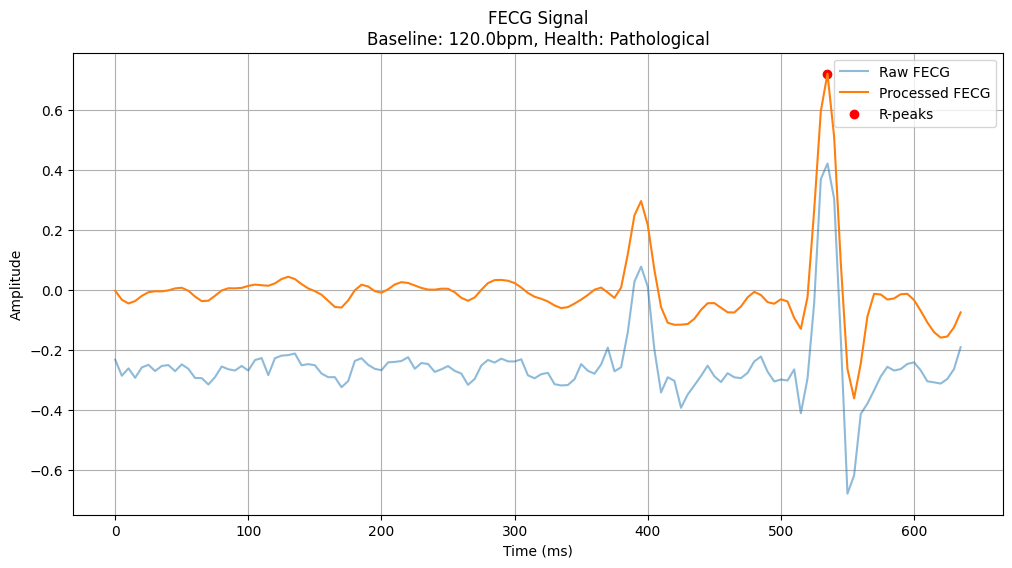


Extracted Features:
                                                             0
baseline_value                                      120.000000
mean_value_of_short_term_variability                  0.000000
mean_value_of_long_term_variability                   0.000000
abnormal_short_term_variability                       1.000000
percentage_of_time_with_abnormal_long_term_vari...  100.000000
accelerations                                         0.000000
decelerations                                         0.000000
mean_amplitude                                       -0.005347
std_amplitude                                         0.124550
skewness                                              2.917662
kurtosis                                             14.273610
peak_to_peak                                          1.084296
zero_crossings                                       16.000000
histogram_width                                       1.084296
histogram_min                     

<ipython-input-27-1f9632047af7>:266: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


<Figure size 1000x400 with 0 Axes>

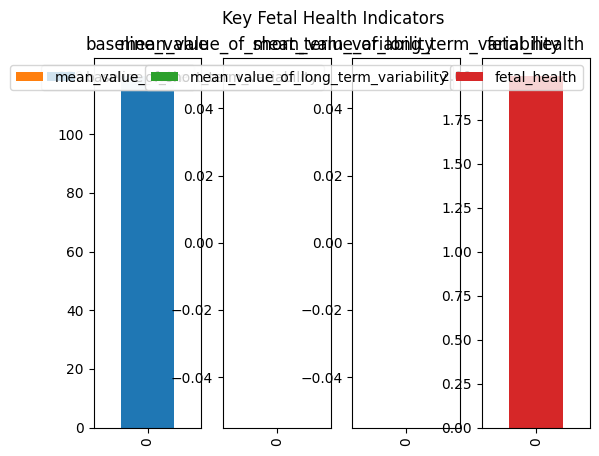

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import mode, kurtosis, skew
import matplotlib.pyplot as plt

class FECGFeatureExtractor:
    def __init__(self, sampling_rate=200):  # 5ms = 200Hz
        """
        Initialize the feature extractor with adjusted parameters for 127 samples at 5ms intervals
        """
        self.sampling_rate = sampling_rate  # 200Hz (5ms per sample)
        self.signal_length = 127  # Fixed length of your signal
        self.duration = 127 * 0.005  # Total duration in seconds (0.635s)

        # Adjusted window sizes for short signal
        self.short_window = int(0.1 * self.sampling_rate)  # 100ms window
        self.long_window = self.signal_length  # Use full signal for long-term features

    def load_data(self, csv_path):
        """Load the extracted FECG data from CSV"""
        df = pd.read_csv(csv_path)
        return df['FECG_extracted'].values

    def preprocess_signal(self, fecg_signal):
        """Preprocess the short FECG signal"""
        # Remove baseline wander with highpass filter
        b, a = signal.butter(3, 1, btype='highpass', fs=self.sampling_rate)
        filtered = signal.filtfilt(b, a, fecg_signal)

        # Additional bandpass to remove noise
        b, a = signal.butter(4, [5, 40], btype='bandpass', fs=self.sampling_rate)
        filtered = signal.filtfilt(b, a, filtered)

        return filtered

    def detect_r_peaks(self, fecg_signal):
        """Detect R-peaks in the short FECG signal"""
        # Enhanced peak detection for short signals
        norm_signal = (fecg_signal - np.mean(fecg_signal)) / np.std(fecg_signal)

        # Find peaks with adaptive threshold
        peaks, _ = signal.find_peaks(
            norm_signal,
            height=1.5,
            distance=int(0.4 * self.sampling_rate)  # 400ms min distance
        )

        return peaks

    def calculate_heart_rate(self, r_peaks):
        """Calculate heart rate from detected R-peaks"""
        if len(r_peaks) < 2:
            return np.nan, np.nan, np.nan  # Not enough peaks

        rr_intervals = np.diff(r_peaks) / self.sampling_rate  # in seconds
        heart_rate = 60 / rr_intervals  # in bpm

        mean_hr = np.mean(heart_rate)
        std_hr = np.std(heart_rate)
        cv_hr = std_hr / mean_hr if mean_hr > 0 else 0  # Coefficient of variation

        return mean_hr, std_hr, cv_hr

    def calculate_variability(self, fecg_signal, r_peaks):
        """Calculate time-domain variability metrics"""
        if len(r_peaks) < 2:
            return {
                'rmssd': 0,
                'sdnn': 0,
                'nn50': 0,
                'pnn50': 0
            }

        rr_intervals = np.diff(r_peaks) / self.sampling_rate * 1000  # in ms

        # Root mean square of successive differences
        rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

        # Standard deviation of NN intervals
        sdnn = np.std(rr_intervals)

        # NN50 count (number of adjacent intervals differing by >50ms)
        nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
        pnn50 = nn50 / len(rr_intervals) * 100 if len(rr_intervals) > 0 else 0

        return {
            'rmssd': rmssd,
            'sdnn': sdnn,
            'nn50': nn50,
            'pnn50': pnn50
        }

    def calculate_waveform_features(self, fecg_signal):
        """Calculate morphological features of the waveform"""
        # Statistical features
        features = {
            'mean_amplitude': np.mean(fecg_signal),
            'std_amplitude': np.std(fecg_signal),
            'skewness': skew(fecg_signal),
            'kurtosis': kurtosis(fecg_signal),
            'peak_to_peak': np.max(fecg_signal) - np.min(fecg_signal)
        }

        # Zero-crossing features
        zero_crossings = np.where(np.diff(np.sign(fecg_signal)))[0]
        features['zero_crossings'] = len(zero_crossings)

        return features

    def extract_features(self, fecg_signal):
        """Extract features from the 127-sample FECG signal"""
        features = {}

        # Preprocess signal
        processed_signal = self.preprocess_signal(fecg_signal)

        # Detect R-peaks
        r_peaks = self.detect_r_peaks(processed_signal)

        # Heart rate features
        mean_hr, std_hr, cv_hr = self.calculate_heart_rate(r_peaks)
        features['baseline_value'] = mean_hr if not np.isnan(mean_hr) else 120  # Default if no peaks

        # Variability features
        variability = self.calculate_variability(processed_signal, r_peaks)
        features.update({
            'mean_value_of_short_term_variability': variability['rmssd'],
            'mean_value_of_long_term_variability': variability['sdnn'],
            'abnormal_short_term_variability': int(variability['rmssd'] < 3),
            'percentage_of_time_with_abnormal_long_term_variability':
                int(variability['sdnn'] < 5) * 100,
            'accelerations': int(len(r_peaks) >= 2 and mean_hr > 140),
            'decelerations': int(len(r_peaks) >= 2 and mean_hr < 100)
        })

        # Waveform morphology features
        waveform_features = self.calculate_waveform_features(processed_signal)
        features.update(waveform_features)

        # Histogram features (using 10 bins for short signal)
        hist, bin_edges = np.histogram(processed_signal, bins=10)
        features.update({
            'histogram_width': bin_edges[-1] - bin_edges[0],
            'histogram_min': bin_edges[0],
            'histogram_max': bin_edges[-1],
            'histogram_number_of_peaks': len(signal.find_peaks(hist)[0]),
            'histogram_number_of_zeroes': np.sum(hist == 0),
            'histogram_mode': bin_edges[np.argmax(hist)],
            'histogram_mean': np.mean(processed_signal),
            'histogram_median': np.median(processed_signal),
            'histogram_variance': np.var(processed_signal),
            'histogram_tendency': np.mean(np.diff(processed_signal))
        })

        # Placeholder features that would need additional data
        features.update({
            'fetal_movement': 0,  # Would need additional sensors
            'uterine_contractions': 0,  # Would need tocography
            'prolongued_decelerations': features['decelerations'],  # Approximation
            'light_decelerations': features['decelerations'],  # Same as decelerations
            'severe_decelerations': 0,  # Rare in short segments
            'fetal_health': self.predict_fetal_health(features)
        })

        return features

    def predict_fetal_health(self, features):
        """Predict fetal health based on extracted features"""
        risk_score = 0

        # Penalize abnormal heart rate
        if features['baseline_value'] < 110 or features['baseline_value'] > 160:
            risk_score += 1

        # Penalize low variability
        if features['mean_value_of_short_term_variability'] < 3:
            risk_score += 1
        if features['mean_value_of_long_term_variability'] < 5:
            risk_score += 1

        # Penalize decelerations
        if features['decelerations']:
            risk_score += 1

        # Determine classification
        if risk_score >= 2:
            return 2  # Pathological
        elif risk_score == 1:
            return 1  # Suspect
        else:
            return 0  # Normal

    def process_csv(self, input_csv, output_csv):
        """Process the input CSV and save features to output CSV"""
        # Load data
        fecg_signal = self.load_data(input_csv)

        # Extract features
        features = self.extract_features(fecg_signal)

        # Create DataFrame and save
        features_df = pd.DataFrame([features])
        features_df.to_csv(output_csv, index=False)

        # Plot the signal with detected peaks
        self.plot_signal_with_features(fecg_signal, features)

        return features_df

    def plot_signal_with_features(self, fecg_signal, features):
        """Plot the signal with detected features"""
        plt.figure(figsize=(12, 6))

        # Preprocess signal for plotting
        processed_signal = self.preprocess_signal(fecg_signal)
        r_peaks = self.detect_r_peaks(processed_signal)

        # Time axis in milliseconds
        time_axis = np.arange(len(fecg_signal)) * 5  # 5ms per sample

        # Plot raw and processed signals
        plt.plot(time_axis, fecg_signal, label='Raw FECG', alpha=0.5)
        plt.plot(time_axis, processed_signal, label='Processed FECG')

        # Mark R-peaks
        if len(r_peaks) > 0:
            plt.scatter(time_axis[r_peaks], processed_signal[r_peaks],
                       color='red', label='R-peaks')

        # Add feature annotations
        plt.title(f"FECG Signal\nBaseline: {features['baseline_value']:.1f}bpm, "
                 f"Health: {['Normal', 'Suspect', 'Pathological'][features['fetal_health']]}")
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)

        # Save the plot
        plt.savefig("fecg_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

# Example usage
if __name__ == '__main__':
    # Initialize the feature extractor with 200Hz sampling rate (5ms intervals)
    extractor = FECGFeatureExtractor(sampling_rate=200)

    # Process the extracted FECG CSV
    input_csv = "extracted_fecg.csv"
    output_csv = "fecg_features.csv"

    # Run the feature extraction pipeline
    features_df = extractor.process_csv(input_csv, output_csv)

    # Display the extracted features
    print("\nExtracted Features:")
    print(features_df.T)

    # Plot key features
    key_features = ['baseline_value', 'mean_value_of_short_term_variability',
                   'mean_value_of_long_term_variability', 'fetal_health']

    plt.figure(figsize=(10, 4))
    features_df[key_features].plot(kind='bar', subplots=True, layout=(1, 4))
    plt.suptitle('Key Fetal Health Indicators')
    plt.tight_layout()
    plt.savefig("fecg_features_plot.png", dpi=300, bbox_inches='tight')
    plt.show()